## Generate a timeseries from the data

First, crawl the instrument for all of the data for the past 30 days.


In [18]:
import requests, json
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import glob
import datetime as dt
import requests
from tqdm import tqdm
import numpy as np
from scipy import signal

__Load data that from classifier__

In [19]:
last_file = sorted(glob.glob("../data/classified-csv/classified_*.csv"))[-1]
df = pd.read_csv(last_file)
df.index = pd.to_datetime(df['dateTime'])

critter_cols = [col for col in df.columns if col not in ['volume_analyzed','dateTime','nsample', 'inhibitTime', 'runTime', 'syringeSize','fileName','volume_analyzed','nsamples']]
not_species = ['dateTime',"inhibitTime","runTime","nsample","volume_analyzed","syringeSize",'fileName','nsamples','nsample','ntotals','volume_analyzed','hab','date']
habs = ["Pseudo-nitzschia","Alexandrium_singlet","Dinophysis","Lingulodinium","Cochlodinium","Prorocentrum","Gymnodinium","Karenia","Protoperidinium"]
species = [cols for cols in df.columns if cols not in not_species]
not_habs = [cols for cols in df.columns if (cols not in not_species) & (cols not in habs)]

# df['hab'] = df['variable'].isin(habs)

def this_week(ax, n_days=10):
    """set x-lim of an axes to the past week"""
    now = dt.datetime.now()
    week_ago = now - dt.timedelta(days=n_days)
    ax.set_xlim(week_ago, now)
    
flowrate = 0.25; # .25 mls per minute
df['volume_analyzed'] = ((df['runTime'] - df['inhibitTime']) * flowrate)/60
df['nsamples'] = df[critter_cols].sum(axis=1)
df[critter_cols] = df[critter_cols].divide(df['volume_analyzed'],axis=0)

__Create list of columns of just the model classes (no metadata) for plotting__

In [20]:
now = dt.datetime.now()
week_ago = now - dt.timedelta(days=8)

top_cols = df.query("index > @week_ago").iloc[-1][critter_cols].sort_values(ascending=False)[:17]
top_cols = list(top_cols.index)
top_cols

['NanoP_less10',
 'Centric',
 'Chaetoceros',
 'Ciliates',
 'Gymnodinium',
 'Prorocentrum',
 'Dictyocha',
 'Phaeocystis',
 'Coccolithophore',
 'Scrip_Het',
 'Akashiwo',
 'Entomoneis',
 'Pennate',
 'Lingulodinium',
 'zooplankton_misc',
 'Det_Cer_Lau',
 'Umbilicosphaera']

0 0 0 NanoP_less10
1 0 1 Centric
2 0 2 Chaetoceros
3 0 3 Ciliates
4 1 0 Gymnodinium
5 1 1 Prorocentrum
6 1 2 Dictyocha
7 1 3 Phaeocystis
8 2 0 Coccolithophore
9 2 1 Scrip_Het
10 2 2 Akashiwo
11 2 3 Entomoneis
12 3 0 Pennate
13 3 1 Lingulodinium
14 3 2 zooplankton_misc
15 3 3 Det_Cer_Lau


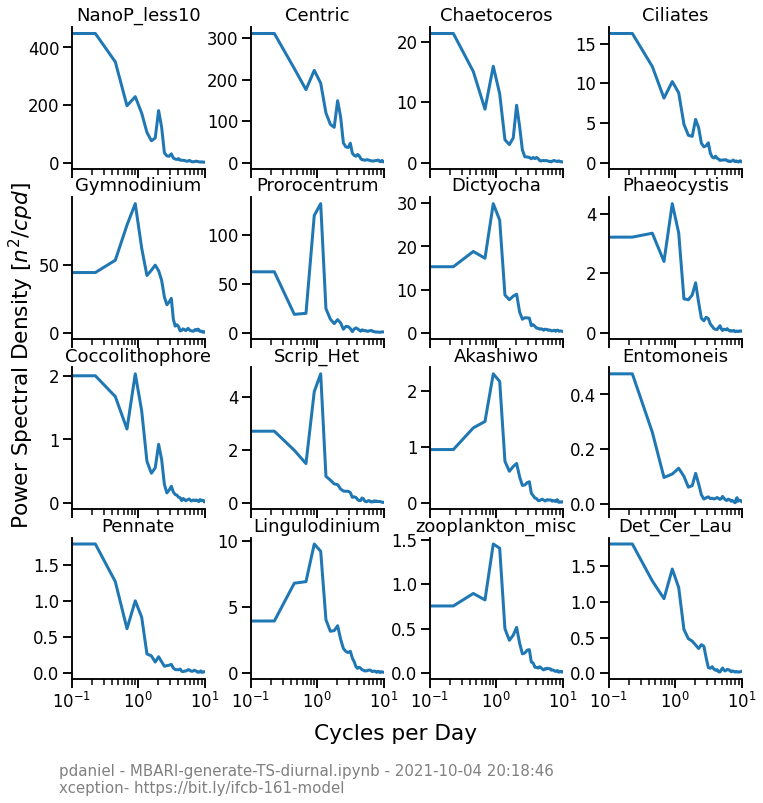

In [21]:
sns.set_context('talk')
fig, ax = plt.subplots(nrows=4,ncols=4,sharex=True)
fig.set_size_inches(12,12)
plt.subplots_adjust(wspace=.35)


# ax.set_title('PSD [welch]: ')

for i, col in enumerate(top_cols[:16]):
    j = i % 4
    k = i // 4
    print(i,k,j,col)
    df_filled = df[col].resample("25T").mean()
    freqs, psd = signal.welch(df_filled.dropna(),fs=57.6,scaling="density")
    
    ax[k,j].semilogx(freqs, psd,label=col, lw=3)
    ax[k,j].set_title(col)
    sns.despine()
ax[k,j].set_xlim(0.1,10)
fig.supxlabel('Cycles per Day', y=.05)
fig.supylabel('Power Spectral Density $[n^2/cpd]$', x=.05)

plt.text(-.1,
         -.8,
         'pdaniel - MBARI-generate-TS-diurnal.ipynb - {}\nxception- https://bit.ly/ifcb-161-model'.format(str(dt.datetime.now())[:-7]),
         transform=ax[-1,0].transAxes,
         fontsize='small',
         color='.5')

plt.savefig('../figures/161-classified-top-psd.png',dpi=300,bbox_inches='tight',transparent=False)

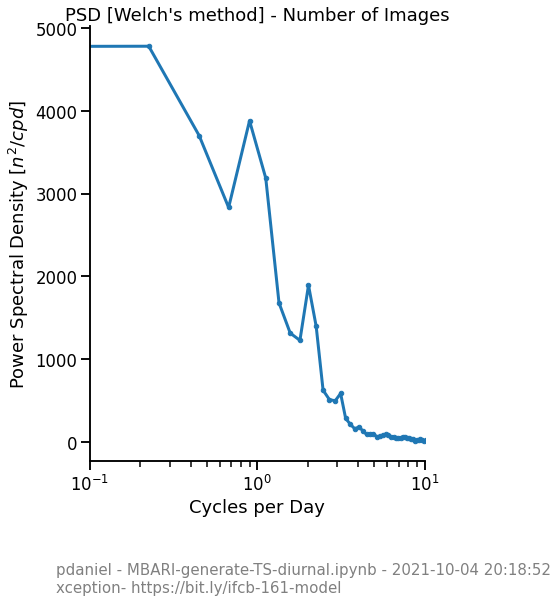

In [22]:
fig, ax = plt.subplots(1)
fig.set_size_inches(6,8)
ax.set_title("PSD [Welch's method] - Number of Images")

df_filled = df["nsamples"].divide(df['volume_analyzed']).resample("25T").mean()
freqs, psd = signal.welch(df_filled.dropna(),fs=57.6)
ax.semilogx(freqs, psd,label='Raw #', lw=3,marker='.')

sns.despine()
ax.set_xlim(0.1,10)
ax.set_xlabel('Cycles per Day')
ax.set_ylabel('Power Spectral Density $[n^2/cpd]$')

plt.text(-.1,
         -.3,
         'pdaniel - MBARI-generate-TS-diurnal.ipynb - {}\nxception- https://bit.ly/ifcb-161-model'.format(str(dt.datetime.now())[:-7]),
         transform=ax.transAxes,
         fontsize='small',
         color='.5')

plt.savefig('../figures/161-classified-all-psd.png',dpi=300,bbox_inches='tight',transparent=False)

## Look at High Resolution of 24 hours ##

__Get Tide data__

In [34]:
url = "https://erddap.cencoos.org/erddap/tabledap/noaa_nos_co_ops_9413450.csvp?time%2Csea_surface_height_above_sea_level_geoid_mllw&time%3E=2021-09-01&time%3C=2021-10-04T19%3A00%3A00Z"
tide = pd.read_csv(url)
tide['dateTime'] = pd.to_datetime(tide["time (UTC)"])
tide = tide.rename(columns={"sea_surface_height_above_sea_level_geoid_mllw (m)":"tide-height"})
tide.index = tide['dateTime']
tide = tide.sort_index()
tide.head()

,time (UTC),tide-height,dateTime
dateTime,,,
2021-09-01 00:00:00+00:00,2021-09-01T00:00:00Z,1.632,2021-09-01 00:00:00+00:00
2021-09-01 00:06:00+00:00,2021-09-01T00:06:00Z,1.620,2021-09-01 00:06:00+00:00
2021-09-01 00:12:00+00:00,2021-09-01T00:12:00Z,1.626,2021-09-01 00:12:00+00:00
2021-09-01 00:18:00+00:00,2021-09-01T00:18:00Z,1.623,2021-09-01 00:18:00+00:00
2021-09-01 00:24:00+00:00,2021-09-01T00:24:00Z,1.626,2021-09-01 00:24:00+00:00


(0.0, 120.0)

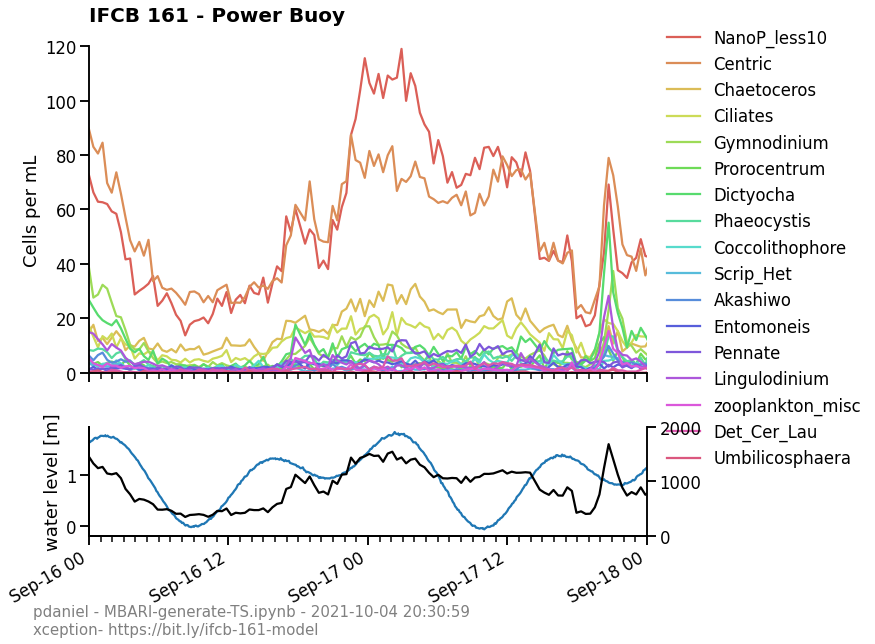

In [56]:
sns.set_context('talk')
fig, (ax,ax2) = plt.subplots(2, sharex=True, gridspec_kw={'height_ratios': [3, 1]})
plt.subplots_adjust(hspace=.25)

fig.set_size_inches(10,10)

colors = sns.color_palette("hls", len(top_cols))
ax.set_prop_cycle('color', colors)

ax.set_title("IFCB 161 - Power Buoy", loc="left",pad=25,fontsize=20,fontweight='bold')


p1 = df[top_cols].plot(ax=ax,)
ax.legend(bbox_to_anchor=(1.01, 1.1), loc='upper left',frameon=False)
ax.set_ylabel("Cells per mL")

# fig.autofmt_xdate()
# Major ticks every 6 months.
major_ticks = mdates.HourLocator(interval=12)
# ax.xaxis.set_major_locator(major_ticks)

# Minor ticks every month.
# minor_ticks = mdates.HourLocator(byhour=range(2,24,2))
minor_ticks = mdates.HourLocator(interval=1)
# ax.xaxis.set_minor_locator(minor_ticks)

# Text in the x axis will be displayed in 'YYYY-mm' format.
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%d'))
plt.xticks(rotation = 45) # Rotates X-Axis Ticks by 45-degrees
ax.set_xlabel("")
# this_week(ax, n_days=3)
# ax.set_ylim(0, 130)
tide['tide-height'].plot(ax=ax2)
ax2_right = ax2.twinx()
ax2_right.set_ylim(0,2000)
sns.despine(ax=ax2_right,right=False)
df['nsamples'].plot(ax=ax2_right,color='k')


ax2.xaxis.set_major_locator(major_ticks)
ax2.xaxis.set_minor_locator(minor_ticks)
# ax.xaxis.set_minor_locator(minor_ticks)
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%b-%d %H'))

plt.xticks(rotation = 45) # Rotates X-Axis Ticks by 45-degrees
ax.set_xlabel("")

ax2.set_ylabel('water level [m]')

ax2.text(-.1,
         -.8,
         'pdaniel - MBARI-generate-TS.ipynb - {}\nxception- https://bit.ly/ifcb-161-model'.format(str(dt.datetime.now())[:-7]),
         transform=ax.transAxes,
         fontsize='small',
         color='.5')

# this_week(ax2, n_days=60)
ax2.set_xlabel("")



sns.despine(ax=ax2)
sns.despine(ax=ax)

fig.autofmt_xdate()

# ax.set_xlim(dt.datetime(2021,9,28),dt.datetime(2021,10,2))
ax2.set_xlim(dt.datetime(2021,9,16),dt.datetime(2021,9,18))
ax.set_ylim(0, 120)
# ax2.set_ylim(0, 2500)



# plt.savefig('../figures/161-classified-all-scaled.png',dpi=300,bbox_inches='tight',transparent=False)




(0.0, 2000.0)

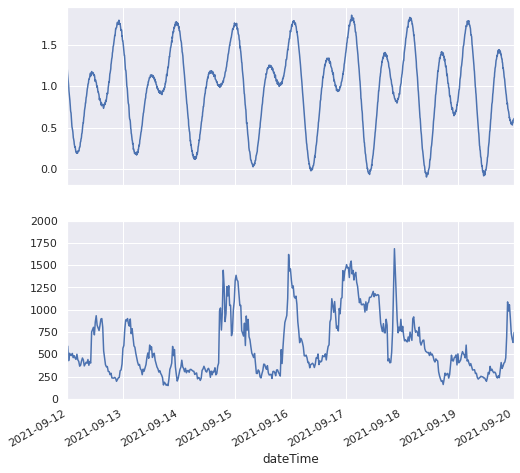

In [67]:
sns.set_theme("notebook")
fig,(ax,ax2) = plt.subplots(2, sharex=True)
fig.set_size_inches(8,8)
tide['tide-height'].plot(ax=ax)
df['nsamples'].plot(ax=ax2)
ax2.set_xlim(dt.datetime(2021,9,12),dt.datetime(2021,9,20))
ax2.set_ylim(0,2000)


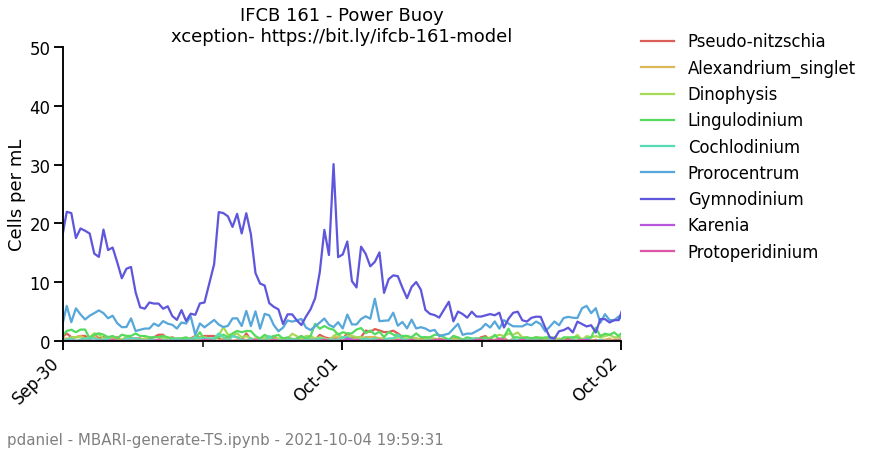

In [7]:
sns.set_context('talk')
fig, ax = plt.subplots(constrained_layout=False)
plt.subplots_adjust(hspace=.1)
fig.set_size_inches(10,6)

colors = sns.color_palette("hls", len(habs))
ax.set_prop_cycle('color', colors)


p1 = df[habs].plot(ax=ax,)
ax.legend(bbox_to_anchor=(1.01, 1.1), loc='upper left',frameon=False)
ax.set_ylabel("Cells per mL")

# fig.autofmt_xdate()
# Major ticks every 6 months.
major_ticks = mdates.DayLocator(interval=1)
ax.xaxis.set_major_locator(major_ticks)

# Minor ticks every month.
minor_ticks = mdates.HourLocator(12)
ax.xaxis.set_minor_locator(minor_ticks)

# Text in the x axis will be displayed in 'YYYY-mm' format.
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%d'))
plt.xticks(rotation = 45) # Rotates X-Axis Ticks by 45-degrees
ax.set_xlabel("")
# this_week(ax, n_days=1)
ax.set_xlim(dt.datetime(2021,9,30),dt.datetime(2021,10,2))
ax2.set_xlim(dt.datetime(2021,9,30),dt.datetime(2021,10,2))
ax.set_ylim(0, 50)

ax.text(-.1,
         -.35,
         'pdaniel - MBARI-generate-TS.ipynb - {}'.format(str(dt.datetime.now())[:-7]),
         transform=ax.transAxes,
         fontsize='small',
         color='.5')

plt.title("IFCB 161 - Power Buoy\nxception- https://bit.ly/ifcb-161-model")



sns.despine()
# plt.savefig('../figures/161-classified-top-habs-7day.png',dpi=300,bbox_inches='tight',transparent=False)

In [ ]:
sns.set_context('talk')
fig, axes = plt.subplots(nrows=7,ncols=2, constrained_layout=False)
plt.subplots_adjust(hspace=.5)
fig.set_size_inches(12,12)
# colors = sns.color_palette(palette="husl", n_colors=5)
# ax.set_prop_cycle('color', colors)
major_ticks = mdates.DayLocator(interval=1)
minor_ticks = mdates.HourLocator(12)


ix = 0
for i in range(2):
    for j in range(7):
        current_ax = axes[j,i]
        current_ax = df[top_cols[ix]].plot(ax=current_ax)
        current_ax.xaxis.set_major_locator(major_ticks)
        current_ax.xaxis.set_minor_locator(minor_ticks)
        current_ax.set_title(top_cols[ix], loc="left",y=.99)
        current_ax.xaxis.set_major_formatter(mdates.DateFormatter('%D'))
        current_ax.set_xlabel("")
#         if ix == 0:
#             current_ax.set_ylim(0,2500)
#         elif ix < 7:
#             current_ax.set_ylim(0,500)
#         else:
#         current_ax.set_ylim(0,250)
        
        if j != 6:
            current_ax.set_xticklabels([])
        ix += 1
        this_week(current_ax,n_days=3)

current_ax.text(-.1,
         -.2,
         'pdaniel - MBARI-generate-TS.ipynb - {}'.format(str(dt.datetime.now())[:-7]),
         transform=ax.transAxes,
         fontsize='small',
         color='.5')
sns.despine()
# plt.savefig('../figures/161-classified-each-top.png',dpi=300,bbox_inches='tight',transparent=False)



In [ ]:
long = pd.melt(df[top_cols].reset_index(), id_vars='dateTime', value_vars=top_cols)
long.head()

In [ ]:
# alt.Chart(long).mark_line(point=True).encode(
#     x='dateTime:T',
#     y='value:Q',
#     color='variable:N'
# )

In [6]:
df_norm = df[critter_cols].divide(df['nsamples'],axis=0)


Only Plot the Top 10 for the enture month

In [7]:
df['nsamples'] = df[critter_cols].sum(axis=1)
df_norm = df[critter_cols].divide(df['nsamples'],axis=0)
top_cols = df.query("index > @week_ago").iloc[-1][critter_cols].sort_values(ascending=False)[:15]
top_cols = list(top_cols.index)
top_cols

['NanoP_less10',
 'Centric',
 'Gymnodinium',
 'Chaetoceros',
 'Ciliates',
 'Dictyocha',
 'Pennate',
 'Phaeocystis',
 'Coccolithophore',
 'Det_Cer_Lau',
 'Ceratium',
 'Prorocentrum',
 'Entomoneis',
 'Asterionellopsis',
 'Cochlodinium']

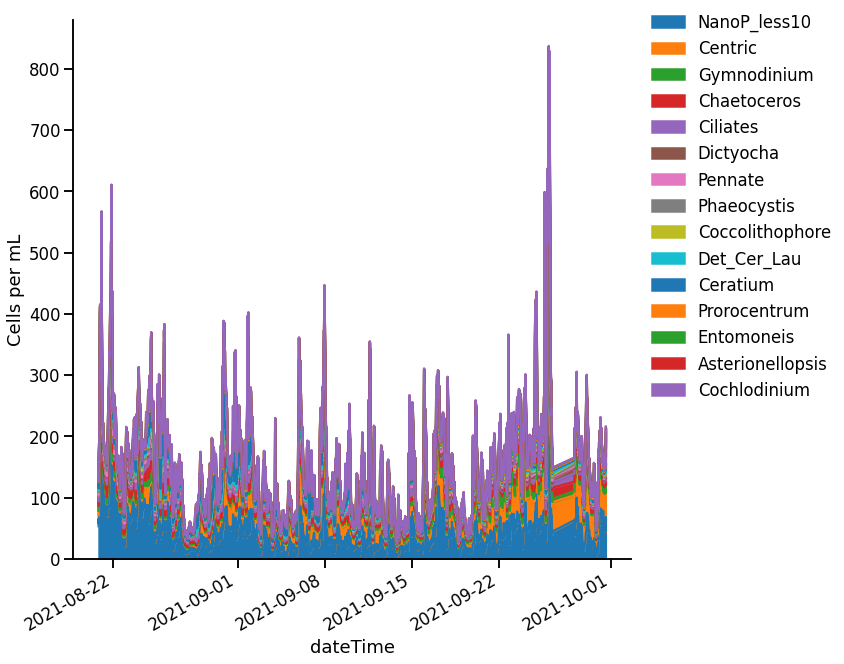

In [8]:
fig, ax = plt.subplots()
fig.set_size_inches(10,11)

# colors = sns.color_palette("hls", len(top_cols))
# ax.set_prop_cycle('color', colors)

colors = sns.color_palette(palette="tab10", n_colors=len(top_cols))
ax.set_prop_cycle('color', colors)
    
df[top_cols].plot.area(ax=ax)
ax.legend(bbox_to_anchor=(1.01, 1.04), loc='upper left',frameon=False)
ax.set_ylabel("Cells per mL")

# this_week(ax,n_days=3)
# ax.set_xlim("2021-09-16")
sns.despine()
# plt.savefig('../figures/161-classified-stacked-top-3-day.png',dpi=300,bbox_inches='tight',transparent=False)

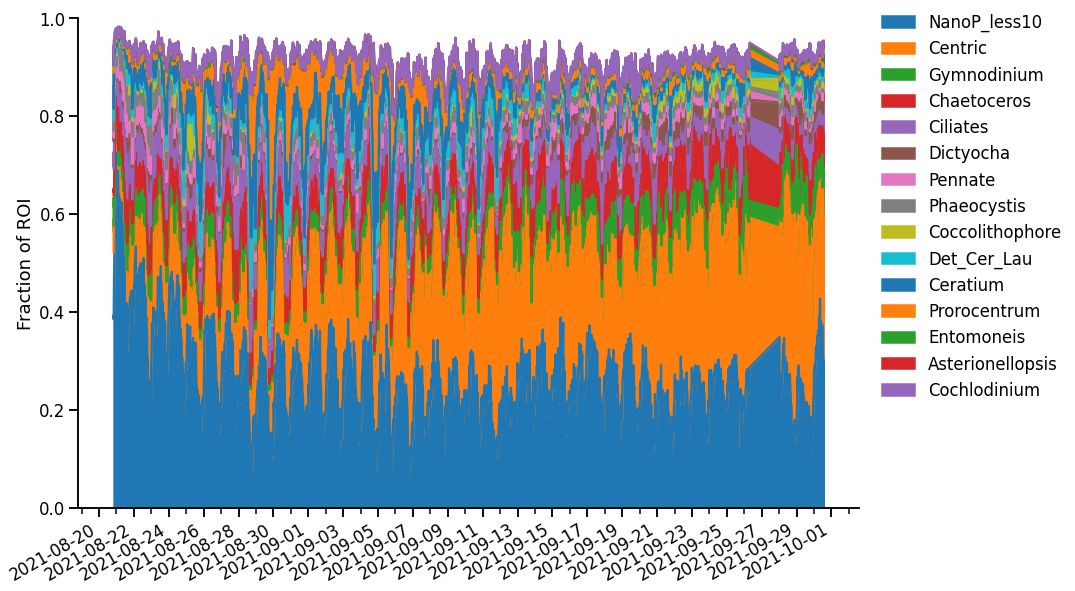

In [9]:
fig, ax = plt.subplots()
fig.set_size_inches(14,10)

colors = sns.color_palette(palette="tab10", n_colors=len(top_cols))
ax.set_prop_cycle('color', colors)

df_norm[top_cols].plot.area(ax=ax)
ax.legend(bbox_to_anchor=(1.01, 1.04), loc='upper left',frameon=False)
ax.set_ylabel("Fraction of ROI")
ax.set_ylim(0,1)
# fig.autofmt_xdate()
# Major ticks every 6 months.
major_ticks = mdates.DayLocator(interval=2)
ax.xaxis.set_major_locator(major_ticks)

# Minor ticks every month.
# minor_ticks = mdates.HourLocator(byhour=range(2,24,2))
minor_ticks = mdates.DayLocator(interval=1)
ax.xaxis.set_minor_locator(minor_ticks)
# this_week(ax,n_days=3)
ax.set_xlabel("")
# ax.set_xlim("2021-09-16")
sns.despine()
# plt.savefig('../figures/161-classified-relative-all.png',dpi=300,bbox_inches='tight',transparent=False)

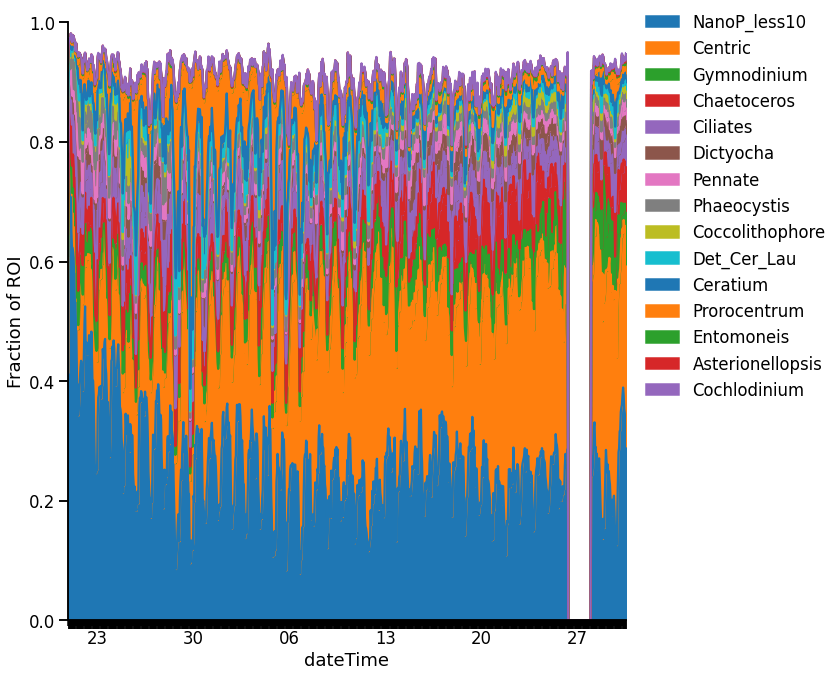

In [13]:
df_norm.resample("25T").mean()

fig, ax = plt.subplots()
fig.set_size_inches(10,11)

colors = sns.color_palette(palette="tab10", n_colors=len(top_cols))
ax.set_prop_cycle('color', colors)

df_norm.resample("1H").mean()[top_cols].plot.area(ax=ax)
ax.legend(bbox_to_anchor=(1.01, 1.04), loc='upper left',frameon=False)
ax.set_ylabel("Fraction of ROI")
ax.set_ylim(0,1)
# fig.autofmt_xdate()
# Major ticks every 6 months.
major_ticks = mdates.DayLocator(interval=2)
ax.xaxis.set_major_locator(major_ticks)

# Minor ticks every month.
# minor_ticks = mdates.HourLocator(byhour=range(2,24,2))
minor_ticks = mdates.DayLocator(interval=1)
ax.xaxis.set_minor_locator(minor_ticks)
# this_week(ax,n_days=3)

# ax.set_xlim("2021-09-16")
sns.despine()
# plt.savefig('../figures/161-classified-relative-top.png',dpi=300,bbox_inches='tight',transparent=False)

In [12]:
df_filled = df['prorocentrum'].resample("25T").mean()
df_filled

KeyError: 'prorocentrum'

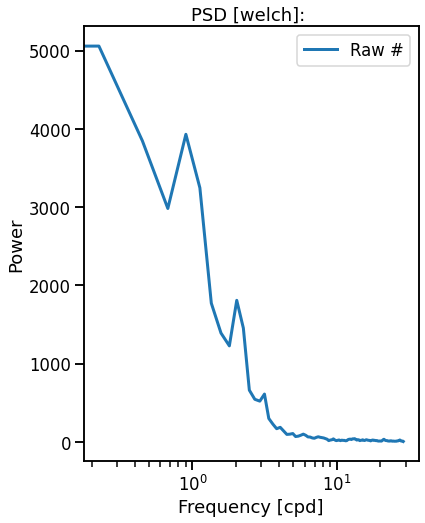

In [11]:
fig, ax = plt.subplots(1)
fig.set_size_inches(6,8)
ax.set_title('PSD [welch]: ')

freqs, psd = signal.welch(df_filled.dropna(),fs=57.6)
ax.semilogx(freqs, psd,label='Raw #', lw=3)
plt.xlabel('Frequency [cpd]')
plt.ylabel('Power')
ax.legend()



In [ ]:
sns.set_context('talk')
fig, ax = plt.subplots(nrows=4,ncols=4,sharex=True)
fig.set_size_inches(12,10)
plt.subplots_adjust(wspace=.35)


# ax.set_title('PSD [welch]: ')

for i, col in enumerate(top_cols[:14]):
    j = i % 4
    k = i // 4
    print(i,k,j)
    df_filled = df[col].resample("25T").mean()
    freqs, psd = signal.welch(df_filled.dropna(),fs=57.6,scaling="density")
    
    ax[k,j].semilogx(freqs, psd,label=col, lw=3)
    ax[k,j].set_title(col)
    sns.despine()
fig.supxlabel('Cycles per Day')
fig.supylabel('Power Spectral Density [samples^2/cpd]')

In [ ]:
ax

In [ ]:
def lanc(numwt, haf):
    """
    Generates a numwt + 1 + numwt lanczos cosine low pass filter with -6dB
    (1/4 power, 1/2 amplitude) point at half
    Parameters
    ----------
    numwt : int
            number of points
    haf : float
          frequency (in 'cpi' of -6dB point, 'cpi' is cycles per interval.
          For hourly data cpi is cph,
    
    From the python-oceans python package
    https://github.com/pyoceans/python-oceans/blob/master/oceans/filters.py
    """
    summ = 0
    numwt += 1
    wt = np.zeros(numwt)

    # Filter weights.
    ii = np.arange(numwt)
    wt = 0.5 * (1.0 + np.cos(np.pi * ii * 1.0 / numwt))
    ii = np.arange(1, numwt)
    xx = np.pi * 2 * haf * ii
    wt[1 : numwt + 1] = wt[1 : numwt + 1] * np.sin(xx) / xx
    summ = wt[1 : numwt + 1].sum()
    xx = wt.sum() + summ
    wt /= xx
    return np.r_[wt[::-1], wt[1 : numwt + 1]]




In [ ]:
freq = 1./25  # 40 Hours
window_size = 48+1+48
pad = np.zeros(window_size) * np.NaN

wt = lanc(window_size, freq)
res = np.convolve(wt, df['num_solutions'], mode='same')
res[-48:] = np.nan
res[:48] = np.nan

df['low'] = res
df['high'] = df['num_solutions'] - df['low']

In [ ]:
np.mean(np.diff(df.index) / np.timedelta64(1, 'm'))

In [ ]:
new_index = pd.date_range(start=df['dateTime'].iloc[0],end=df['dateTime'].iloc[-1],freq="23T44S")
df_reindexed = df_norm.reindex(new_index,method="nearest",tolerance='25min',limit=2)

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(10,11)

df_reindexed[top_cols].plot.area(ax=ax,cmap="tab10")

ax.legend(bbox_to_anchor=(1.01, 1.04), loc='upper left',frameon=False)
ax.set_ylabel("fraction of total classified per bin")
ax.set_xlim(df_reindexed.index[0],df_reindexed.index[-1]);
ax.set_title("10 Ten Classes from Tina (SC Wharf IFCB)\n Generated from class_scores.csv")

ax.text(0,
         -.1,
         'pdaniel - 3-generate-TS.ipynb - {}'.format(str(dt.datetime.now())[:-7]),
         transform=ax.transAxes,
         fontsize='small',
         color='.5')

sns.despine()
# plt.savefig('./figures/top_data_stacked_normal.png',dpi=300,bbox_inches='tight',transparent=False)

## Load Whaft Shore Station ##

In [ ]:
shore = pd.read_csv('./data/210609.csv',skiprows=[1])
shore['dateTime'] = pd.to_datetime(shore["Date Time"])
shore.index = shore['dateTime']
shore2 = pd.read_csv('./data/210622.csv',skiprows=[1])
shore2['dateTime'] = pd.to_datetime(shore2["Date Time"])
shore2.index = shore2['dateTime']
shore = pd.concat((shore,shore2))


In [ ]:
shore['Chl'].plot()

In [ ]:
sns.set_context('talk')
fig,ax = plt.subplots()
fig.set_size_inches(10,6)
ax2 = ax.twinx()
ax2.plot(df['dateTime'], df['nsamples'], c='#C71585',lw=0,marker='.',label='IFCB Images')
ax2.set_ylabel('Images per Bin\n[per 5ml]',color = "#C71585")
ax.plot(shore['dateTime'], shore['Chl.1'],color='g',label='Wharf Fluor')
ax.set_ylabel('Chl-a [RFU]', color='g')
ax.legend(fancybox=False, loc=1,frameon=False)
ax2.legend(fancybox=False, loc=2 ,frameon=False)
fig.autofmt_xdate()
ax.set_xlim(dt.datetime(2021,6,18),dt.datetime(2021,7,1))
ax2.set_xlim(dt.datetime(2021,6,18),dt.datetime(2021,7,1))


plt.title("SC Wharf: Chlorophyll-a and IFCB Images")
ax.text(-.1,
         -.4,
         'pdaniel - 3-generate-TS.ipynb - {}'.format(str(dt.datetime.now())[:-7]),
         transform=ax.transAxes,
         fontsize='small',
         color='.5')

# sns.despine()

In [ ]:
sns.set_context('talk')
fig,ax = plt.subplots()
fig.set_size_inches(10,6)
ax2 = ax.twinx()
ax2.plot(df['dateTime'], df['nsamples'], c='#C71585',lw=0,marker='.',label='IFCB Images')
ax2.set_ylabel('Images per Bin\n[per 5ml]',color = "#C71585")
ax.plot(shore['dateTime'], shore['Chl.1'],color='g',label='Wharf Fluor')
ax.set_ylabel('Chl-a [RFU]', color='g')
ax.legend(fancybox=False, loc=1,frameon=False)
ax2.legend(fancybox=False, loc=2 ,frameon=False)
fig.autofmt_xdate()
ax.set_xlim(dt.datetime(2021,6,30),dt.datetime(2021,7,10))
ax2.set_xlim(dt.datetime(2021,6,30),dt.datetime(2021,7,10))


plt.title("SC Wharf: Chlorophyll-a and IFCB Images")
ax.text(-.1,
         -.4,
         'pdaniel - 3-generate-TS.ipynb - {}'.format(str(dt.datetime.now())[:-7]),
         transform=ax.transAxes,
         fontsize='small',
         color='.5')

# sns.despine()